In [1]:
%load_ext autoreload
%autoreload 2

# Copied from `train` function in train_simple.py:L78
import yaml
import torch
import matplotlib.pyplot as plt
from models.yolo import Model
from utils.general import check_dataset

device = 'cpu'
hyp = 'data/hyps/hyp.scratch-low.yaml'

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

In [2]:
cfg = 'models/yolov5n_nuscenes.yaml'
data = 'data/nuscenes.yaml'
data_dict = check_dataset(data)

nc = int(data_dict["nc"])  # number of classes
model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create

Overriding model.yaml nc=4 with nc=15

                 from  n    params  module                                  arguments                     
  0                -1  1      1760  models.common.Conv                      [3, 16, 6, 2, 2]              
  1                -1  1      4672  models.common.Conv                      [16, 32, 3, 2]                
  2                -1  1      4800  models.common.C3                        [32, 32, 1]                   
  3                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  4                -1  2     29184  models.common.C3                        [64, 64, 2]                   
  5                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  6                -1  3    156928  models.common.C3                        [128, 128, 3]                 
  7                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]             

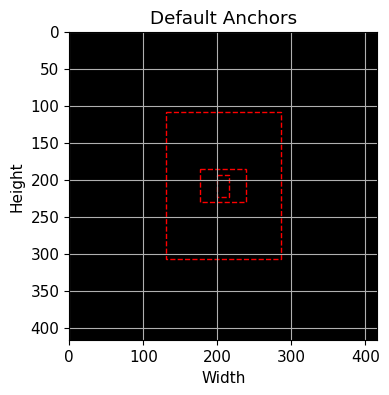

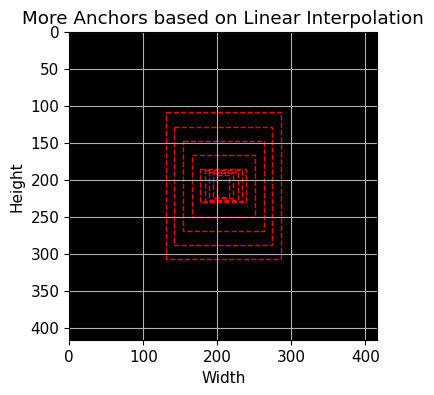

In [3]:
# [TODO] Draw anchors
%matplotlib inline

def draw_anchors(anchors, strides, img_size=416, prefix=None):
    plt.figure(figsize=(4, 4))
    for i, value in enumerate(anchors):
        if isinstance(value, torch.Tensor):
            value = value.view(2)
        if strides is not None:
            width, height = value[0]*strides[i], value[1]*strides[i]
        else:
            width, height = value[0], value[1]
        rect = plt.Rectangle(((img_size - width) / 2, (img_size - height) / 2), width, height, fill=False, edgecolor='r', linestyle='dashed')
        plt.gca().add_patch(rect)
        
    plt.xlim(0, img_size)
    plt.ylim(0, img_size)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(prefix)
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.grid(True)
    plt.gca().set_facecolor('black')
    plt.gca().invert_yaxis()
    plt.show()

anchors = model.model[-1].anchors
strides = model.model[-1].stride

draw_anchors(anchors, strides, prefix = "Default Anchors")

cfg_new_anchors = 'models/yolov5n_nuscenes_more_anchors.yaml'
with open(cfg_new_anchors, errors="ignore") as f:
    cfg = yaml.safe_load(f)  # load hyps dict
    
anchors_new = cfg["anchors"]
strides_new = None 

draw_anchors(anchors_new, strides_new, prefix = "More Anchors based on Linear Interpolation")

In [4]:
from utils.dataloaders import create_dataloader
from utils.general import check_img_size, colorstr

imgsz = 416
batch_size = 1
single_cls = False
seed = 0

train_path = data_dict["train"]
test_path = data_dict["test"]

gs = max(int(model.stride.max()), 32)  # grid size (max stride)
imgsz = check_img_size(imgsz, gs, floor=gs * 2)  # verify imgsz is gs-multiple

train_loader, dataset = create_dataloader(
    train_path,
    imgsz,
    batch_size,
    gs,
    single_cls,
    hyp=hyp,
    augment=True,
    cache=None,
    rect=False,
    rank=-1,
    workers=8,
    image_weights=False,
    quad=False,
    prefix=colorstr("train: "),
    shuffle=True,
    seed=seed,
)

test_loader, dataset = create_dataloader(
    test_path,
    imgsz,
    batch_size,
    gs,
    single_cls,
    hyp=hyp,
    augment=False,
    cache=None,
    rect=False,
    rank=-1,
    workers=8,
    image_weights=False,
    quad=False,
    prefix=colorstr("test: "),
    shuffle=False,
    seed=seed,
)

train: Scanning /home/mmc-server4/Server/Datasets_hdd/nuscenes_det2d/train.cache
test: Scanning /home/mmc-server4/Server/Datasets_hdd/nuscenes_det2d/test.cache..


In [5]:
for imgs, targets, paths, _ in train_loader:
    imgs = imgs.to(device, non_blocking=True).float() / 255  # uint8 to float32, 0-255 to 0.0-1.0
    break

In [6]:
from models.common import DetectMultiBackend
from utils.torch_utils import select_device

weights = 'yolov5n.pt'
data = 'data/nuscenes.yaml'
half = False  # use FP16 half-precision inference
dnn = False  # use OpenCV DNN for ONNX inference
device = select_device('cpu')

model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half)

# inference
model.eval()
with torch.no_grad():
    pred = model(imgs)  # forward

YOLOv5 🚀 2024-6-14 Python-3.8.19 torch-2.3.0 CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients, 4.5 GFLOPs


In [7]:
from utils.general import non_max_suppression

conf_thres = 0.25  # confidence threshold
iou_thres = 0.45  # NMS IOU threshold
max_det = 1000  # maximum detections per image
classes = None
agnostic_nms = False  # class-agnostic NMS

pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)

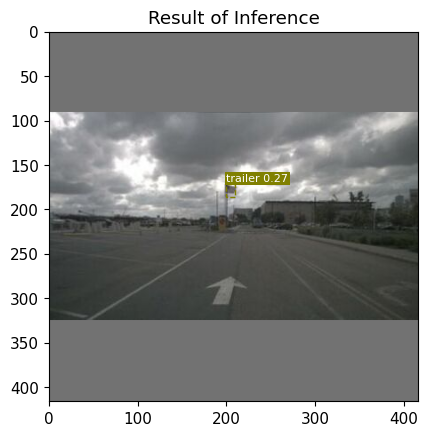

In [32]:
# [TODO] draw predictions (see detect.py:L178)
import matplotlib.patches as patches
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import numpy as np

save_dir = "result"

class_names = data_dict["names"]
color_dict = {
    0: 'red',
    1: 'green',
    2: 'blue',
    3: 'yellow',
    4: 'magenta',
    5: 'cyan',
    6: 'maroon',
    7: 'lime',
    8: 'navy',
    9: 'olive',
    10: 'purple',
    11: 'teal',
    12: 'silver',
    13: 'gray',
    14: 'orange'
}


def plot_inference(img, anchors, img_shape=(416, 416), prefix = "show"):
    fig, ax = plt.subplots(1)
    if img.dim() == 4:
        img = img[0].permute(1, 2, 0).cpu().numpy()
    else:
        img = img.permute(1, 2, 0).cpu().numpy()
    ax.imshow(img, extent=[0, img_shape[1], img_shape[0], 0])

    for i, anchor in enumerate(anchors):
        for j in range(anchor.shape[0]):
            x1, y1, x2, y2, conf ,label = anchor[j, :]
            w = x2 - x1
            h = y2 - y1
            rect = patches.Rectangle(
                (x1, y1), w, h,
                linewidth=1, edgecolor=color_dict[int(label)], facecolor='none', linestyle='--'
            )
            ax.add_patch(rect)
            ax.text(x1, y1 - 12, f'{class_names[int(label)]} {conf:.2f}',  color='white', fontsize=8, 
                    verticalalignment='top', bbox={'facecolor': color_dict[int(label)], 'edgecolor': 'none', 'alpha': 1, 'pad': 1})

    plt.title("Result of Inference")
    plt.savefig(f'./{save_dir}/inference.png')
    if prefix == "show":
        plt.show()
    plt.close(fig)  # Close the figure to free memory
    
    # Convert the plot to a numpy array and return it
    canvas = FigureCanvas(fig)
    canvas.draw()
    img_inferenced = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    img_inferenced = img_inferenced.reshape(canvas.get_width_height()[::-1] + (3,))

    return img_inferenced

_ = plot_inference(img=imgs,anchors=pred)

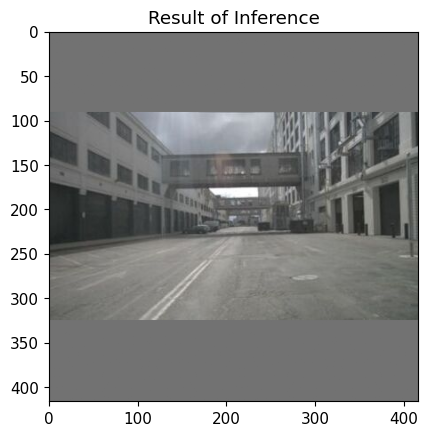

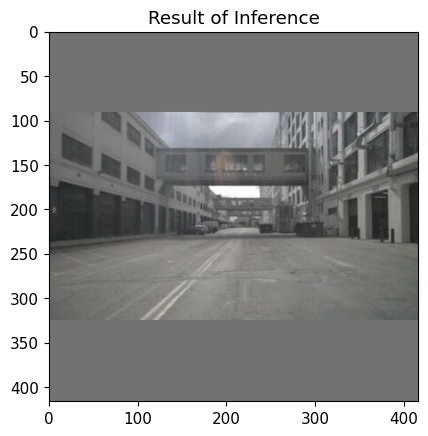

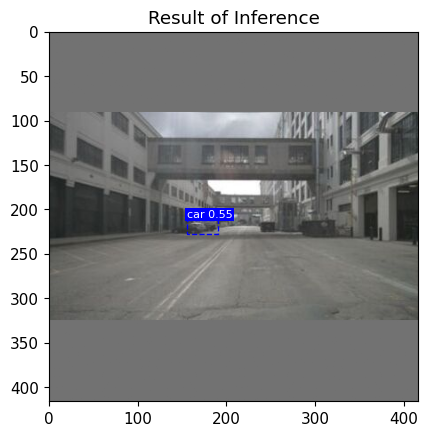

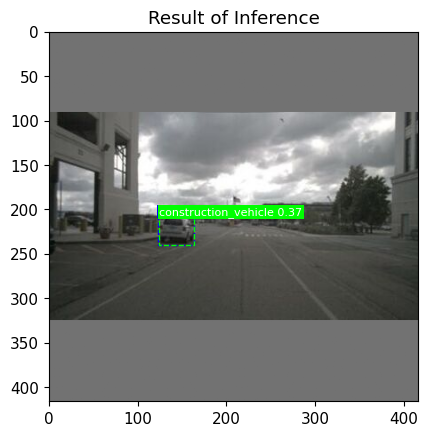

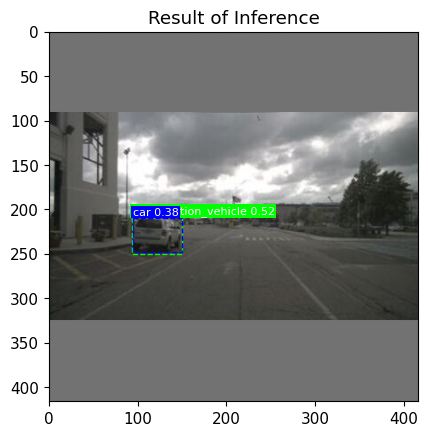

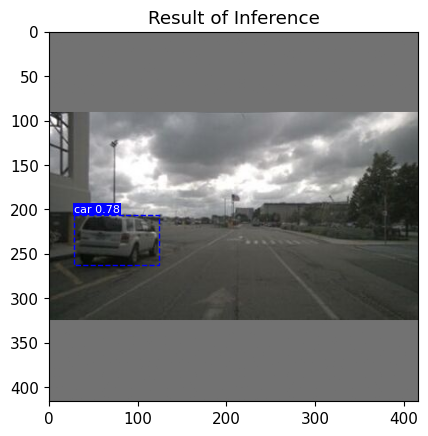

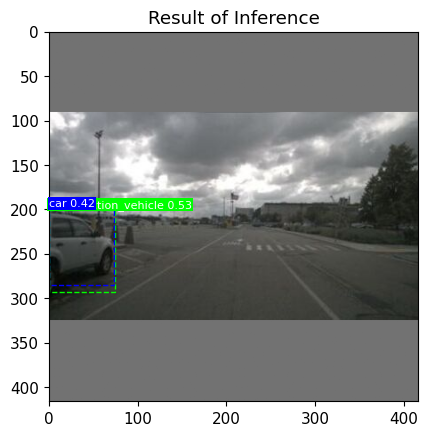

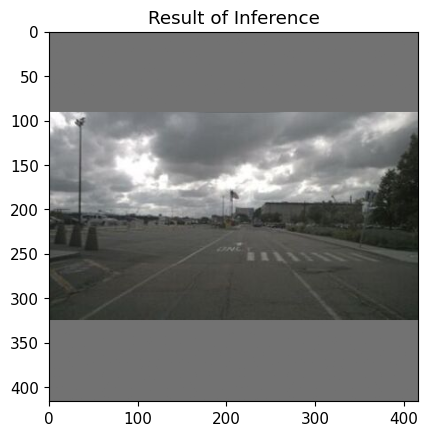

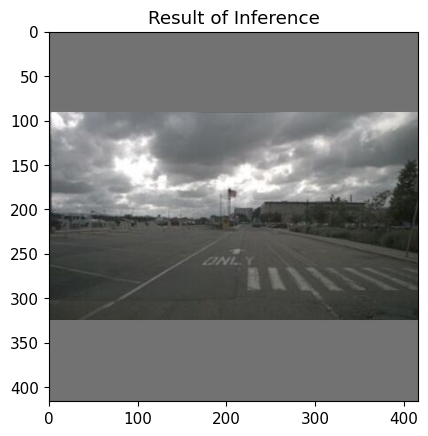

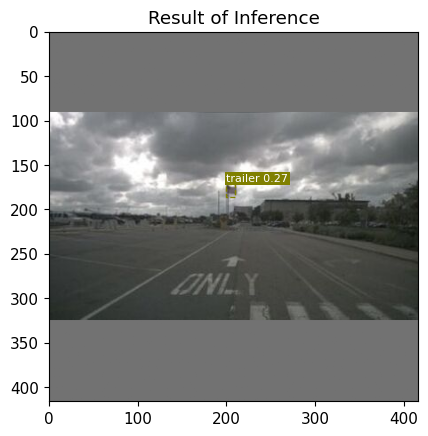

Save Inference Images to Video : ./result/inference_video.mp4


In [28]:
import cv2 
    
video_file = f"./{save_dir}/inference_video.mp4"

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = 5
video_writer = None

frame_count = 0
max_frames = 10

for imgs, targets, paths, _ in test_loader:
    if frame_count >= max_frames:
        break
    
    imgs = imgs.to(device, non_blocking=True).float() / 255
    
    with torch.no_grad():
        pred = model(imgs)

    pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
    
    for i, det in enumerate(pred):
        # frame = plot_inference(imgs[i], [det], prefix="don't show")
        frame = plot_inference(imgs[i], [det])
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    
        if video_writer is None and frame is not None:
            h, w, _ = frame_bgr.shape
            video_writer = cv2.VideoWriter(video_file, fourcc, fps, (w, h))
        video_writer.write(frame_bgr)
        frame_count += 1

if video_writer is not None:
    video_writer.release()
print(f"Save Inference Images to Video : {video_file}")